In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.one_hot import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [15]:
dataset = pd.read_csv("Credit.csv", sep=',').drop("Unnamed: 0", axis=1)
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

train.shape, val.shape, test.shape

((256, 11), (64, 11), (80, 11))

In [18]:
train.Rating.describe()

count    256.000000
mean     350.593750
std      155.613823
min       93.000000
25%      234.250000
50%      342.500000
75%      439.250000
max      982.000000
Name: Rating, dtype: float64

In [42]:
train.head()

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
179   58.026   7499     560      5   67         11  Female      No      No   
270   15.866   3085     217      1   39         13    Male      No      No   
323  182.728  13913     982      4   98         17    Male      No     Yes   
399   18.701   5524     415      5   64          7  Female      No      No   
40    34.950   3327     253      3   54         14  Female      No      No   

            Ethnicity  Balance  
179         Caucasian     1237  
270         Caucasian      136  
323         Caucasian     1999  
399             Asian      966  
40   African American       50

In [20]:
train.corr(numeric_only=True)

Income     Limit    Rating     Cards       Age  Education  \
Income     1.000000  0.780951  0.780247 -0.022704  0.148597  -0.057559   
Limit      0.780951  1.000000  0.996779  0.016119  0.100745  -0.079295   
Rating     0.780247  0.996779  1.000000  0.063025  0.102405  -0.088679   
Cards     -0.022704  0.016119  0.063025  1.000000  0.094197  -0.112172   
Age        0.148597  0.100745  0.102405  0.094197  1.000000  -0.003901   
Education -0.057559 -0.079295 -0.088679 -0.112172 -0.003901   1.000000   
Balance    0.471305  0.874921  0.876267  0.101356  0.030089  -0.074093   

            Balance  
Income     0.471305  
Limit      0.874921  
Rating     0.876267  
Cards      0.101356  
Age        0.030089  
Education -0.074093  
Balance    1.000000

In [21]:
train.dtypes

Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Gender        object
Student       object
Married       object
Ethnicity     object
Balance        int64
dtype: object

In [23]:
train.Gender.value_counts()

Female    130
 Male     126
Name: Gender, dtype: int64

In [25]:
train.Student.value_counts()

No     232
Yes     24
Name: Student, dtype: int64

In [26]:
train.Married.value_counts()

Yes    161
No      95
Name: Married, dtype: int64

In [27]:
train.Ethnicity.value_counts()

Caucasian           124
African American     67
Asian                65
Name: Ethnicity, dtype: int64

<AxesSubplot: xlabel='Income_bucket', ylabel='Rating_bucket'>

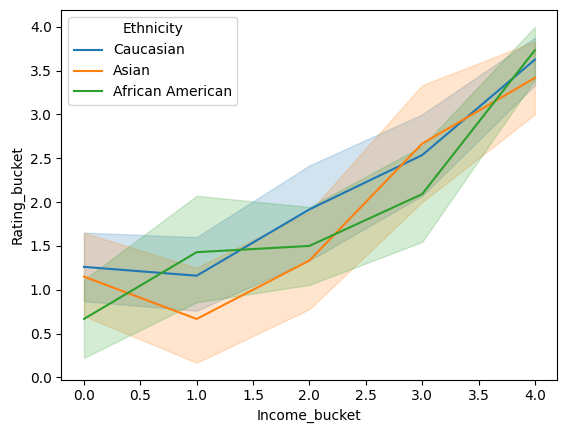

In [40]:
sns.lineplot(
    train.assign(
        Income_bucket = lambda df_: pd.qcut(df_.Income, q=5, labels=False),
        Rating_bucket = lambda df_: pd.qcut(df_.Rating, q=5, labels=False)
    ) , 
    x='Income_bucket',
    y='Rating_bucket',
    hue='Ethnicity'
)

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self, cols, min_q = 0.01, max_q = 0.99):
        self.cols = cols
        self.min_q = min_q
        self.max_q = max_q
    
    def fit(self, X, y=None):
        self.thresholds_dict = {
            col: (np.quantile(X[col], self.min_q), np.quantile(X[col], self.max_q))
            for col in self.cols
        }

        return self
    
    def transform(self, X):
        return X.assign(**{
            col: X[col].clip(lower=self.thresholds_dict[col][0], upper=self.thresholds_dict[col][1])
            for col in self.cols
        })

In [57]:
loo_enc = LeaveOneOutEncoder(cols=['Ethnicity'])
ord_enc = OrdinalEncoder(cols=['Gender', 'Student', 'Married'])
outRem_enc = OutlierRemover(cols=['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Balance'])

In [89]:
model_pipeline = Pipeline([
    ('loo_enc', LeaveOneOutEncoder(cols=['Ethnicity'])),
    ('ord_enc', OrdinalEncoder(cols=['Gender', 'Student', 'Married'])),
    ('outliers', OutlierRemover(cols=['Income', 'Limit', 'Cards', 'Age', 'Education', 'Balance'])),
    ('lr', LinearRegression())
])

In [90]:
model_pipeline.fit(X=train.drop("Rating", axis=1), y=train['Rating'])

Pipeline(steps=[('loo_enc', LeaveOneOutEncoder(cols=['Ethnicity'])),
                ('ord_enc',
                 OrdinalEncoder(cols=['Gender', 'Student', 'Married'],
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Female    1
 Male     2
NaN      -2
dtype: int64},
                                         {'col': 'Student',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN   -2
dtype: int64},
                                         {'col': 'Married',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN   -2
dtype: int64}])),
                ('outliers',
                 OutlierRemover(cols=['Income', 'Limit', 'Cards', 'Age',
                                      'Education', 'Balance'])),
                ('lr', LinearRegression())])

In [91]:
mean_squared_error(
    y_pred=model_pipeline.predict(train.drop("Rating", axis=1)),
    y_true=train['Rating'],
    squared=False
)

15.57801362376165

In [93]:
pd.DataFrame(
    model_pipeline.steps[-1][-1].coef_,
    index = model_pipeline.steps[-1][-1].feature_names_in_
).abs().sort_values(0, ascending=False)

0
Student    15.086731
Married     5.629238
Cards       4.918901
Gender      1.124492
Income      0.458174
Education   0.094874
Ethnicity   0.067827
Limit       0.055949
Balance     0.039440
Age         0.033406

In [ ]:
config = {
    "encoders_cols": {
        'loo_enc': ['Ethnicity'],
        'ord_enc': ['Gender', 'Student', 'Married'],
        'outliers': ['Income', 'Limit', 'Cards', 'Age', 'Education', 'Balance']
    }
}

In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.one_hot import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
import yaml
import joblib 

class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self, cols, min_q = 0.01, max_q = 0.99):
        self.cols = cols
        self.min_q = min_q
        self.max_q = max_q
    
    def fit(self, X, y=None):
        self.thresholds_dict = {
            col: (np.quantile(X[col], self.min_q), np.quantile(X[col], self.max_q))
            for col in self.cols
        }

        return self
    
    def transform(self, X):
        return X.assign(**{
            col: X[col].clip(lower=self.thresholds_dict[col][0], upper=self.thresholds_dict[col][1])
            for col in self.cols
        })

def fit(dataset_path="Credit.csv", target_name='Rating', config="config.yaml"):
    dataset = pd.read_csv(dataset_path, sep=',').drop("Unnamed: 0", axis=1)
    train, test = train_test_split(dataset, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)

    with open(config, 'r') as f:
        config = yaml.safe_load(f)

    model_pipeline = Pipeline([
        ('loo_enc', LeaveOneOutEncoder(cols=config['encoders_cols']['loo_enc'])),
        ('ord_enc', OrdinalEncoder(cols=config['encoders_cols']['ord_enc'])),
        ('outliers', OutlierRemover(cols=config['encoders_cols']['outliers'])),
        ('lr', LinearRegression())
    ])

    model_pipeline.fit(X=train.drop(target_name, axis=1), y=train[target_name])
    
    with open("model_pipeline.joblib", 'wb') as f:
        joblib.dump(model_pipeline, f)

    train.to_parquet("train.parquet")
    test.to_parquet("test.parquet")
    val.to_parquet("val.parquet")
    

    
def predict(data_path='.', fold='test', model_path='model_pipeline.joblib', target_name='Rating', config="config.yaml"):
    dataset = pd.read_parquet(f"{data_path}/{fold}.parquet")

    with open(model_path, 'rb') as f:
        model_pipeline = joblib.load(f)

    predictions = model_pipeline.predict(X=dataset.drop(target_name, axis=1))

    metric = mean_squared_error(
        y_pred=predictions,
        y_true=dataset[target_name],
        squared=False
    )

    with open(f"predictions_{fold}.yaml", "w") as f:
        yaml.dump({
            "metric": float(metric), 
            "predictions": list(map(int, predictions.tolist()))
        }, f)

In [136]:
fit()

In [137]:
predict(fold='train'), predict(fold='val'), predict(fold='test') 

(None, None, None)

In [103]:
with open("config.yaml", "w") as f:
    yaml.dump(config, f)